In [1]:
import os
seed = 42
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from tensorflow.random import set_seed

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
def load_dataset(filename):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns += list(np.array(A_var, dtype='U20'))
        columns += list(np.array(T_var, dtype='U20'))
        columns += list(np.array(X_s_var, dtype='U20'))
        columns += list(np.array(X_v_var, dtype='U20'))
        columns += list(np.array(W_var, dtype='U20'))
        columns += ['RUL']
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
    
    return pd.DataFrame(data=train_set, columns=columns), pd.DataFrame(data=test_set, columns=columns)

In [8]:
start_time = time.process_time()  
train_set, test_set = load_dataset(filename)
print('')
print("Operation time (sec): " , (time.process_time() - start_time))
print('')
print ("Train set shape: " + str(train_set.shape))
print ("Test set shape: " + str(test_set.shape))


Operation time (sec):  3.421875

Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [9]:
def unit_cycle_info(df, compute_cycle_len=False):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        print('Unit: ', i, ' - Number of flight cycles: ', num_cycles)
        
    if compute_cycle_len:
        cycle_ids = np.unique(df['cycle'])
        print('Total number of cycles: ', len(cycle_ids))
        min_len = np.inf
        max_len = 0
        for i in cycle_ids:
            cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
            if cycle_len < min_len:
                min_len = cycle_len
            elif cycle_len > max_len:
                max_len = cycle_len
        print('Min cycle length: ', min_len)
        print('Max cycle length: ', max_len)
    
    return unit_ids

In [10]:
# Filter constant and quasi-constant features
def get_quasi_constant_features(dataset, variance_th=0.01, debug=True):
    constant_filter = VarianceThreshold(threshold=variance_th)
    constant_filter.fit(dataset)
    constant_features = [col for col in dataset.columns 
                         if col not in dataset.columns[constant_filter.get_support()]]
    
    if debug:
        print("Number of non-constant features: ", len(dataset.columns[constant_filter.get_support()]))
        
        print("Number of quasi-constant features: ", len(constant_features))
        print("Quasi-constant features: ")
        for col in constant_features:
            print(col)
    return constant_features

def get_non_correlated_features(dataset, corr_th=0.9, debug=True):
    corr_mat = dataset.corr()
    corr_mat = np.abs(corr_mat)
    
    N = corr_mat.shape[0]
    columns = np.full((N,), True, dtype=bool)
    for i in range(N):
        for j in range(i+1, N):
            if corr_mat.iloc[i, j] >= corr_th:
                if columns[j]:
                    columns[j] = False
    if debug:        
        correlated_features = dataset.columns[~columns]
        print("Number of correlated features: ", len(correlated_features))
        print("Correlated features: ")
        for col in correlated_features:
            print(col)
    
    selected_columns = dataset.columns[columns]
    return selected_columns

In [ ]:
unit_ids = unit_cycle_info(train_set)

In [11]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=0)

train_idxs, val_idxs = next(gss.split(train_set, groups=train_set['unit']))

train_split = train_set.iloc[train_idxs]
val_split = train_set.iloc[val_idxs]

In [12]:
unit_cycle_info(train_split)

Engine units in df:  [ 2.  5. 16. 18.]
Unit:  2.0  - Number of flight cycles:  75
Unit:  5.0  - Number of flight cycles:  89
Unit:  16.0  - Number of flight cycles:  63
Unit:  18.0  - Number of flight cycles:  71


array([ 2.,  5., 16., 18.])

In [13]:
unit_cycle_info(val_split)

Engine units in df:  [10. 20.]
Unit:  10.0  - Number of flight cycles:  82
Unit:  20.0  - Number of flight cycles:  66


array([10., 20.])

In [14]:
from sklearn.utils import shuffle

train_split = shuffle(train_split)
val_split = shuffle(val_split)

In [15]:
y_train = train_split['RUL']
x_train = train_split.drop(['RUL'], axis=1)

y_val = val_split['RUL']
x_val = val_split.drop(['RUL'], axis=1)

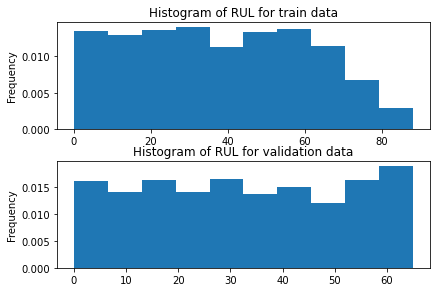

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()
y_train.plot(kind='hist', ax=ax1, density=1)
ax1.set_title("Histogram of RUL for train data")

y_val.plot(kind='hist', ax=ax2, density=1)
ax2.set_title("Histogram of RUL for validation data")
plt.savefig(os.path.join(output_path, 'hist_RUL_final.png'), format='png', dpi=300) 

Text(0.5, 1.0, 'Histogram of RUL for test data')

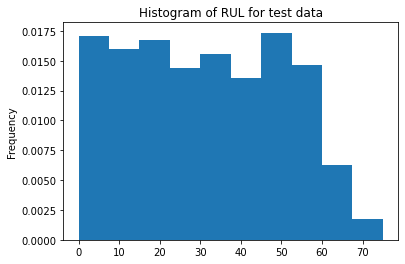

In [38]:
y_test.plot(kind='hist', density=1)
plt.title("Histogram of RUL for test data")

In [16]:
constant_features = get_quasi_constant_features(x_train)
x_train.drop(labels=constant_features, axis=1, inplace=True)
x_val.drop(labels=constant_features, axis=1, inplace=True)
print("Train shape: ", x_train.shape)

Number of non-constant features:  34
Number of quasi-constant features:  12
Quasi-constant features: 
Fc
fan_eff_mod
fan_flow_mod
LPC_eff_mod
LPC_flow_mod
HPC_eff_mod
HPC_flow_mod
HPT_eff_mod
HPT_flow_mod
LPT_eff_mod
LPT_flow_mod
Mach
Train shape:  (3542576, 34)


In [17]:
# Remove highly correlated features
selected_columns = get_non_correlated_features(x_train)

# sensors = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
# scenario_descriptors = ['alt', 'TRA', 'T2']
# selected_columns = sensors + scenario_descriptors

x_train = x_train[selected_columns]
x_val = x_val[selected_columns]
print("Train shape: ", x_train.shape)

Number of correlated features:  26
Correlated features: 
T48
T50
P2
P21
P24
Ps30
P40
P50
Nf
Nc
Wf
T40
P30
P45
W21
W22
W25
W31
W32
W48
W50
SmHPC
phi
alt
TRA
T2
Train shape:  (3542576, 8)


In [18]:
# Drop auxiliary data columns
auxiliary_columns = ['cycle', 'hs', 'Fc']
x_train.drop(labels=[x for x in auxiliary_columns if x in x_train.columns], axis=1, inplace=True)
x_val.drop(labels=[x for x in auxiliary_columns if x in x_val.columns], axis=1, inplace=True)

In [19]:
# Drop unit column
x_train.drop(labels=['unit'], axis=1, inplace=True)
x_val.drop(labels=['unit'], axis=1, inplace=True)

In [20]:
x_train

,T24,T30,P15,SmFan,SmLPC
182551,550.888980,1306.479774,9.622313,19.681756,8.384708
574647,561.303490,1325.186357,10.754276,19.751889,7.928827
649299,595.249862,1424.331179,15.149541,16.689345,9.464689
4191956,551.963131,1320.353331,8.921765,18.452537,8.412098
3595223,542.617587,1296.348414,8.096627,18.181070,7.602757
...,...,...,...,...,...
3309041,549.595529,1314.793157,8.956166,18.669542,8.579318
4464277,541.695075,1299.578809,8.095847,18.381011,8.511837
3181795,578.083560,1385.723822,12.065196,18.075116,9.033319
3721018,564.360358,1351.631391,10.387135,18.454717,8.835110


In [21]:
y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)
x_test = x_test[x_train.columns]

In [22]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [23]:
from sklearn.metrics import mean_squared_error

def cmapss_score_function(actual, predictions):
    diff = actual - predictions
    alpha = np.full_like(diff, 1/10)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/13
    return np.sum(np.exp(alpha * np.abs(diff)))

def evaluation(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2E}\n'.format(label, mse, rmse, 
                                                                     Decimal(cmapss_score)))
    
def plot_loss_curves(history, output_path=''):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    
def plot_rul(expected, predicted):
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()

In [ ]:
def mlp_model(input_dim, hidden_layer_size, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=input_dim, 
                    kernel_initializer='normal', activation=activation))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
input_dim = x_train_scaled.shape[1]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(os.path.join(output_path, 'mlp_model_baseline.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model = mlp_model(input_dim)

In [ ]:
history = model.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val),
                    epochs=200, batch_size=512, verbose=1, callbacks=[es, mc])

In [27]:
hidden_layer_sizes = [50, 100, 200, 300, 500]
activation_functions = ['relu', 'tanh', 'sigmoid']
batch_sizes = list(2**np.arange(9, 13))
dropout_list = list(np.arange(0, 5) / 10)

In [28]:
def create_mlp_model(input_dim, hidden_layer_size, dropout, weights_file, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=input_dim, 
                    kernel_initializer='normal', activation=activation))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [33]:
ITERATIONS = 60 

results = pd.DataFrame(columns=['loss_train', 'loss_val', 'nodes', 'activation', 'batch_size', 'dropout', 'training_time'])  
weights_file = 'mlp_weights.h5'
# epochs = 200
epochs = 50

for i in range(ITERATIONS):
    layer_size = random.sample(hidden_layer_sizes, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_sizes, 1)[0]
    dropout = random.sample(dropout_list, 1)[0]
    
    print('\n\nIteration ', i+1)
    print('Layer size = {}, activation = {}, batch size = {}, dropout = {}'.format(layer_size,
                                                                                  activation,
                                                                                  batch_size,
                                                                                  dropout))
    
    input_dim = x_train_scaled.shape[1]
    model = create_mlp_model(input_dim, layer_size, dropout, weights_file)
    
    start_time = time.time()
    history = model.fit(x_train_scaled, y_train,
                        validation_data=(x_val_scaled, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=2)
    training_time = time.time() - start_time
    print("Training time for iteration {}: {}".format(i + 1, training_time))
    
    mse_train = history.history['loss'][-1]
    mse_val = history.history['val_loss'][-1]
    
    
    # append results
    d = {'loss_train': mse_train, 
         'loss_val': mse_val,
         'nodes':layer_size,
         'activation':activation, 
         'batch_size':batch_size, 
         'dropout': dropout,
         'training_time': training_time}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results.to_csv(os.path.join(output_path, 'tuning_results.csv'))



Iteration  1
Layer size = 100, activation = relu, batch size = 4096, dropout = 0.3
Epoch 1/50
865/865 - 4s - loss: 818.4907 - val_loss: 398.3312
Epoch 2/50
865/865 - 3s - loss: 314.5118 - val_loss: 366.9552
Epoch 3/50
865/865 - 3s - loss: 285.8918 - val_loss: 356.8907
Epoch 4/50
865/865 - 3s - loss: 266.8344 - val_loss: 352.2576
Epoch 5/50
865/865 - 3s - loss: 249.4501 - val_loss: 343.9261
Epoch 6/50
865/865 - 3s - loss: 231.8464 - val_loss: 336.0140
Epoch 7/50
865/865 - 3s - loss: 214.7188 - val_loss: 331.4146
Epoch 8/50
865/865 - 3s - loss: 199.6379 - val_loss: 327.9305
Epoch 9/50
865/865 - 3s - loss: 186.9749 - val_loss: 325.3551
Epoch 10/50
865/865 - 3s - loss: 177.8873 - val_loss: 324.1916
Epoch 11/50
865/865 - 3s - loss: 171.5891 - val_loss: 322.8754
Epoch 12/50
865/865 - 3s - loss: 166.8181 - val_loss: 321.2634
Epoch 13/50
865/865 - 3s - loss: 163.0659 - val_loss: 319.0897
Epoch 14/50
865/865 - 3s - loss: 160.2722 - val_loss: 316.4202
Epoch 15/50
865/865 - 3s - loss: 157.7714 

Epoch 23/50
6920/6920 - 21s - loss: 142.5112 - val_loss: 270.8837
Epoch 24/50
6920/6920 - 21s - loss: 142.3551 - val_loss: 271.3700
Epoch 25/50
6920/6920 - 20s - loss: 142.3488 - val_loss: 269.5215
Epoch 26/50
6920/6920 - 19s - loss: 142.2084 - val_loss: 268.6650
Epoch 27/50
6920/6920 - 20s - loss: 142.1132 - val_loss: 265.4964
Epoch 28/50
6920/6920 - 19s - loss: 142.0426 - val_loss: 266.9849
Epoch 29/50
6920/6920 - 19s - loss: 142.0344 - val_loss: 262.3175
Epoch 30/50
6920/6920 - 19s - loss: 142.0628 - val_loss: 263.9802
Epoch 31/50
6920/6920 - 19s - loss: 141.6036 - val_loss: 268.6519
Epoch 32/50
6920/6920 - 19s - loss: 141.1811 - val_loss: 265.0557
Epoch 33/50
6920/6920 - 19s - loss: 141.1789 - val_loss: 265.6983
Epoch 34/50
6920/6920 - 19s - loss: 140.9750 - val_loss: 259.6786
Epoch 35/50
6920/6920 - 19s - loss: 140.7414 - val_loss: 261.3293
Epoch 36/50
6920/6920 - 19s - loss: 140.6194 - val_loss: 260.0631
Epoch 37/50
6920/6920 - 20s - loss: 140.6537 - val_loss: 258.3746
Epoch 38/5

Epoch 45/50
1730/1730 - 9s - loss: 96.2601 - val_loss: 197.6980
Epoch 46/50
1730/1730 - 9s - loss: 96.1894 - val_loss: 198.2617
Epoch 47/50
1730/1730 - 9s - loss: 95.9604 - val_loss: 196.9119
Epoch 48/50
1730/1730 - 9s - loss: 95.8419 - val_loss: 194.6739
Epoch 49/50
1730/1730 - 9s - loss: 95.7247 - val_loss: 193.9533
Epoch 50/50
1730/1730 - 9s - loss: 95.4777 - val_loss: 193.6474
Training time for iteration 5: 454.2009446620941


Iteration  6
Layer size = 300, activation = tanh, batch size = 4096, dropout = 0.1
Epoch 1/50
865/865 - 5s - loss: 620.5825 - val_loss: 372.4251
Epoch 2/50
865/865 - 5s - loss: 262.7896 - val_loss: 353.0065
Epoch 3/50
865/865 - 5s - loss: 229.9757 - val_loss: 341.2409
Epoch 4/50
865/865 - 5s - loss: 201.6724 - val_loss: 327.2952
Epoch 5/50
865/865 - 5s - loss: 177.4448 - val_loss: 319.3315
Epoch 6/50
865/865 - 5s - loss: 160.0800 - val_loss: 311.0482
Epoch 7/50
865/865 - 5s - loss: 148.8618 - val_loss: 307.8676
Epoch 8/50
865/865 - 5s - loss: 141.3578 - val_l

Epoch 17/50
865/865 - 7s - loss: 127.2687 - val_loss: 279.4161
Epoch 18/50
865/865 - 7s - loss: 126.7146 - val_loss: 278.4604
Epoch 19/50
865/865 - 7s - loss: 126.2888 - val_loss: 275.6756
Epoch 20/50
865/865 - 7s - loss: 125.8923 - val_loss: 272.7062
Epoch 21/50
865/865 - 7s - loss: 125.4150 - val_loss: 271.6313
Epoch 22/50
865/865 - 7s - loss: 125.1102 - val_loss: 270.9930
Epoch 23/50
865/865 - 7s - loss: 124.9182 - val_loss: 270.6113
Epoch 24/50
865/865 - 7s - loss: 124.5282 - val_loss: 269.2213
Epoch 25/50
865/865 - 7s - loss: 124.1828 - val_loss: 265.0808
Epoch 26/50
865/865 - 7s - loss: 123.8461 - val_loss: 265.5946
Epoch 27/50
865/865 - 7s - loss: 123.7095 - val_loss: 262.4717
Epoch 28/50
865/865 - 7s - loss: 123.3394 - val_loss: 262.6719
Epoch 29/50
865/865 - 7s - loss: 123.2001 - val_loss: 258.2931
Epoch 30/50
865/865 - 7s - loss: 122.8858 - val_loss: 260.0453
Epoch 31/50
865/865 - 7s - loss: 122.7181 - val_loss: 257.4184
Epoch 32/50
865/865 - 7s - loss: 122.5603 - val_loss: 2

Epoch 40/50
6920/6920 - 21s - loss: 64.7588 - val_loss: 142.4423
Epoch 41/50
6920/6920 - 20s - loss: 64.5322 - val_loss: 145.5239
Epoch 42/50
6920/6920 - 20s - loss: 64.3905 - val_loss: 143.3393
Epoch 43/50
6920/6920 - 20s - loss: 64.1726 - val_loss: 142.6071
Epoch 44/50
6920/6920 - 20s - loss: 64.0193 - val_loss: 140.5734
Epoch 45/50
6920/6920 - 20s - loss: 63.8755 - val_loss: 140.9116
Epoch 46/50
6920/6920 - 21s - loss: 63.5885 - val_loss: 138.8769
Epoch 47/50
6920/6920 - 20s - loss: 63.4284 - val_loss: 143.9260
Epoch 48/50
6920/6920 - 21s - loss: 63.2656 - val_loss: 138.9468
Epoch 49/50
6920/6920 - 21s - loss: 63.0978 - val_loss: 139.1892
Epoch 50/50
6920/6920 - 20s - loss: 62.9506 - val_loss: 141.3914
Training time for iteration 10: 1021.9127204418182


Iteration  11
Layer size = 50, activation = relu, batch size = 1024, dropout = 0.3
Epoch 1/50
3460/3460 - 11s - loss: 511.3810 - val_loss: 363.2689
Epoch 2/50
3460/3460 - 10s - loss: 279.4815 - val_loss: 349.5229
Epoch 3/50
3460/346

Epoch 11/50
1730/1730 - 9s - loss: 127.7338 - val_loss: 289.9198
Epoch 12/50
1730/1730 - 9s - loss: 127.0535 - val_loss: 287.9686
Epoch 13/50
1730/1730 - 9s - loss: 126.5704 - val_loss: 285.2843
Epoch 14/50
1730/1730 - 9s - loss: 126.0587 - val_loss: 283.3799
Epoch 15/50
1730/1730 - 9s - loss: 125.5129 - val_loss: 278.1486
Epoch 16/50
1730/1730 - 9s - loss: 125.0910 - val_loss: 274.7921
Epoch 17/50
1730/1730 - 9s - loss: 124.8204 - val_loss: 274.9618
Epoch 18/50
1730/1730 - 9s - loss: 124.4067 - val_loss: 275.6575
Epoch 19/50
1730/1730 - 9s - loss: 124.0489 - val_loss: 272.2033
Epoch 20/50
1730/1730 - 9s - loss: 123.7300 - val_loss: 270.8949
Epoch 21/50
1730/1730 - 9s - loss: 123.4734 - val_loss: 267.9414
Epoch 22/50
1730/1730 - 9s - loss: 123.1490 - val_loss: 264.7600
Epoch 23/50
1730/1730 - 9s - loss: 122.8695 - val_loss: 266.6800
Epoch 24/50
1730/1730 - 9s - loss: 122.4853 - val_loss: 262.4298
Epoch 25/50
1730/1730 - 9s - loss: 122.3373 - val_loss: 258.6313
Epoch 26/50
1730/1730 - 9

Epoch 33/50
1730/1730 - 6s - loss: 88.5673 - val_loss: 237.2279
Epoch 34/50
1730/1730 - 6s - loss: 88.1909 - val_loss: 235.7367
Epoch 35/50
1730/1730 - 6s - loss: 87.7842 - val_loss: 233.2042
Epoch 36/50
1730/1730 - 6s - loss: 87.4117 - val_loss: 233.2148
Epoch 37/50
1730/1730 - 6s - loss: 87.0302 - val_loss: 229.0452
Epoch 38/50
1730/1730 - 6s - loss: 86.6606 - val_loss: 230.3887
Epoch 39/50
1730/1730 - 6s - loss: 86.3006 - val_loss: 224.5490
Epoch 40/50
1730/1730 - 6s - loss: 85.9295 - val_loss: 225.4094
Epoch 41/50
1730/1730 - 6s - loss: 85.6278 - val_loss: 222.7458
Epoch 42/50
1730/1730 - 6s - loss: 85.2894 - val_loss: 221.7805
Epoch 43/50
1730/1730 - 6s - loss: 84.9918 - val_loss: 221.9808
Epoch 44/50
1730/1730 - 6s - loss: 84.7212 - val_loss: 220.6304
Epoch 45/50
1730/1730 - 6s - loss: 84.4289 - val_loss: 221.3266
Epoch 46/50
1730/1730 - 6s - loss: 84.0913 - val_loss: 218.5683
Epoch 47/50
1730/1730 - 6s - loss: 83.8348 - val_loss: 216.2608
Epoch 48/50
1730/1730 - 6s - loss: 83.55

Epoch 1/50
6920/6920 - 20s - loss: 337.5848 - val_loss: 340.4140
Epoch 2/50
6920/6920 - 20s - loss: 188.7397 - val_loss: 329.3845
Epoch 3/50
6920/6920 - 20s - loss: 157.2552 - val_loss: 332.2244
Epoch 4/50
6920/6920 - 20s - loss: 148.9326 - val_loss: 325.9721
Epoch 5/50
6920/6920 - 19s - loss: 144.5429 - val_loss: 316.5474
Epoch 6/50
6920/6920 - 20s - loss: 141.6776 - val_loss: 309.9805
Epoch 7/50
6920/6920 - 19s - loss: 139.3140 - val_loss: 307.7002
Epoch 8/50
6920/6920 - 19s - loss: 137.3121 - val_loss: 300.4829
Epoch 9/50
6920/6920 - 20s - loss: 135.9661 - val_loss: 290.6904
Epoch 10/50
6920/6920 - 19s - loss: 134.7773 - val_loss: 291.0313
Epoch 11/50
6920/6920 - 20s - loss: 134.0382 - val_loss: 282.1867
Epoch 12/50
6920/6920 - 20s - loss: 133.1622 - val_loss: 283.4385
Epoch 13/50
6920/6920 - 20s - loss: 132.4239 - val_loss: 278.4883
Epoch 14/50
6920/6920 - 19s - loss: 131.9063 - val_loss: 279.8432
Epoch 15/50
6920/6920 - 20s - loss: 131.5407 - val_loss: 273.4707
Epoch 16/50
6920/69

Epoch 22/50
6920/6920 - 20s - loss: 133.6613 - val_loss: 268.1625
Epoch 23/50
6920/6920 - 20s - loss: 133.3333 - val_loss: 268.6742
Epoch 24/50
6920/6920 - 20s - loss: 133.3416 - val_loss: 267.9915
Epoch 25/50
6920/6920 - 20s - loss: 133.3517 - val_loss: 268.3556
Epoch 26/50
6920/6920 - 20s - loss: 133.2561 - val_loss: 264.2823
Epoch 27/50
6920/6920 - 20s - loss: 133.0532 - val_loss: 263.9502
Epoch 28/50
6920/6920 - 20s - loss: 133.0493 - val_loss: 262.7930
Epoch 29/50
6920/6920 - 20s - loss: 132.9836 - val_loss: 261.5589
Epoch 30/50
6920/6920 - 20s - loss: 132.8248 - val_loss: 261.4804
Epoch 31/50
6920/6920 - 20s - loss: 132.9078 - val_loss: 264.0240
Epoch 32/50
6920/6920 - 20s - loss: 132.7671 - val_loss: 262.0619
Epoch 33/50
6920/6920 - 20s - loss: 132.7908 - val_loss: 264.3912
Epoch 34/50
6920/6920 - 20s - loss: 132.7171 - val_loss: 257.1230
Epoch 35/50
6920/6920 - 20s - loss: 132.7558 - val_loss: 262.9280
Epoch 36/50
6920/6920 - 20s - loss: 132.4505 - val_loss: 260.4357
Epoch 37/5

Epoch 44/50
3460/3460 - 10s - loss: 75.9759 - val_loss: 184.6777
Epoch 45/50
3460/3460 - 10s - loss: 75.7090 - val_loss: 182.1012
Epoch 46/50
3460/3460 - 10s - loss: 75.4569 - val_loss: 183.1448
Epoch 47/50
3460/3460 - 10s - loss: 75.1087 - val_loss: 179.9207
Epoch 48/50
3460/3460 - 10s - loss: 74.8485 - val_loss: 178.3254
Epoch 49/50
3460/3460 - 10s - loss: 74.6414 - val_loss: 177.5517
Epoch 50/50
3460/3460 - 10s - loss: 74.4018 - val_loss: 177.4938
Training time for iteration 22: 508.1955189704895


Iteration  23
Layer size = 100, activation = sigmoid, batch size = 512, dropout = 0.0
Epoch 1/50
6920/6920 - 20s - loss: 317.6396 - val_loss: 338.9895
Epoch 2/50
6920/6920 - 19s - loss: 158.6900 - val_loss: 326.1947
Epoch 3/50
6920/6920 - 19s - loss: 129.0345 - val_loss: 317.4272
Epoch 4/50
6920/6920 - 19s - loss: 119.0809 - val_loss: 311.9202
Epoch 5/50
6920/6920 - 19s - loss: 113.2277 - val_loss: 305.9840
Epoch 6/50
6920/6920 - 19s - loss: 109.4832 - val_loss: 299.3370
Epoch 7/50
6920/6

Epoch 13/50
3460/3460 - 11s - loss: 119.2382 - val_loss: 275.0432
Epoch 14/50
3460/3460 - 10s - loss: 118.8303 - val_loss: 268.3265
Epoch 15/50
3460/3460 - 10s - loss: 118.3128 - val_loss: 263.8106
Epoch 16/50
3460/3460 - 10s - loss: 117.9671 - val_loss: 259.5367
Epoch 17/50
3460/3460 - 10s - loss: 117.7393 - val_loss: 260.7649
Epoch 18/50
3460/3460 - 10s - loss: 117.4314 - val_loss: 260.0495
Epoch 19/50
3460/3460 - 10s - loss: 117.0715 - val_loss: 255.7380
Epoch 20/50
3460/3460 - 10s - loss: 116.9141 - val_loss: 254.2758
Epoch 21/50
3460/3460 - 10s - loss: 116.7060 - val_loss: 251.3938
Epoch 22/50
3460/3460 - 10s - loss: 116.4632 - val_loss: 252.6469
Epoch 23/50
3460/3460 - 10s - loss: 116.2617 - val_loss: 251.0083
Epoch 24/50
3460/3460 - 10s - loss: 115.9223 - val_loss: 250.8032
Epoch 25/50
3460/3460 - 10s - loss: 115.8838 - val_loss: 247.5342
Epoch 26/50
3460/3460 - 10s - loss: 115.5854 - val_loss: 247.5060
Epoch 27/50
3460/3460 - 10s - loss: 115.3360 - val_loss: 241.9401
Epoch 28/5

Epoch 36/50
3460/3460 - 13s - loss: 106.6664 - val_loss: 213.0913
Epoch 37/50
3460/3460 - 13s - loss: 106.4311 - val_loss: 211.2146
Epoch 38/50
3460/3460 - 13s - loss: 106.1086 - val_loss: 214.8145
Epoch 39/50
3460/3460 - 12s - loss: 105.8066 - val_loss: 206.7649
Epoch 40/50
3460/3460 - 14s - loss: 105.6004 - val_loss: 207.8244
Epoch 41/50
3460/3460 - 13s - loss: 105.3723 - val_loss: 208.2259
Epoch 42/50
3460/3460 - 12s - loss: 105.0813 - val_loss: 205.2911
Epoch 43/50
3460/3460 - 13s - loss: 104.9110 - val_loss: 204.9417
Epoch 44/50
3460/3460 - 13s - loss: 104.5792 - val_loss: 209.2916
Epoch 45/50
3460/3460 - 12s - loss: 104.4322 - val_loss: 209.7850
Epoch 46/50
3460/3460 - 13s - loss: 104.3760 - val_loss: 208.8218
Epoch 47/50
3460/3460 - 13s - loss: 104.1234 - val_loss: 202.2343
Epoch 48/50
3460/3460 - 13s - loss: 104.0403 - val_loss: 204.7503
Epoch 49/50
3460/3460 - 13s - loss: 103.8496 - val_loss: 200.9763
Epoch 50/50
3460/3460 - 13s - loss: 103.5792 - val_loss: 203.9798
Training t

KeyboardInterrupt: 

In [34]:
results

,loss_train,loss_val,nodes,activation,batch_size,dropout,training_time
0,141.270920,280.966309,100,relu,4096,0.3,174.071320
1,118.353813,228.756119,200,sigmoid,1024,0.2,590.047491
2,140.220764,259.083313,50,relu,512,0.2,1009.990901
3,101.891281,202.350983,300,tanh,512,0.1,1004.642402
4,95.477684,193.647354,500,sigmoid,2048,0.1,454.200945
5,104.074989,221.310486,300,tanh,4096,0.1,255.013270
6,132.791992,260.311462,200,relu,1024,0.4,511.600897
7,120.163582,238.935272,500,tanh,4096,0.4,328.075791
8,103.352516,208.065033,300,tanh,1024,0.1,515.796587
9,62.950584,141.391449,500,tanh,512,0.0,1021.912720


In [38]:
best_params = results[results['loss_val'] == results['loss_val'].min()]

In [58]:
layer_size = int(best_params['nodes'])
activation = best_params['activation']
batch_size = int(best_params['batch_size'])
dropout = float(best_params['dropout'])
epochs = 200

In [25]:
def create_mlp_model(input_dim, hidden_layer_sizes, weights_file, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))

    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [ ]:
input_dim = x_train_scaled.shape[1]
weights_file = os.path.join(output_path, 'mlp_weights.h5')

layer_sizes = [500]
epochs = 200
batch_size = 512

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(os.path.join(output_path, 'mlp_model_baseline.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model = create_mlp_model(input_dim, layer_sizes, weights_file)
model.summary()
    
start_time = time.time()
history = model.fit(x_train_scaled, y_train,
                    validation_data=(x_val_scaled, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[es, mc])
training_time = time.time() - start_time

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 3,501
Trainable params: 3,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
6920/6920 [==============================] - ETA: 0s - loss: 415.3812
Epoch 00001: val_loss improved from inf to 387.10233, saving model to DS02\mlp_model_baseline.h5
6920/6920 [==============================] - 22s 3ms/step - loss: 415.3812 - val_loss: 387.1023
Epoch 2/200
6915/6920 [============================>.] - ETA: 0s - loss: 287.6894
Epoch 00002: val_loss improved from 387.10233 to 373.24988, saving model to DS02\mlp_model_baseline.h5
6920/6920 [==============================] - 21s 3ms/ste

Epoch 31/200
6917/6920 [============================>.] - ETA: 0s - loss: 104.3065
Epoch 00031: val_loss did not improve from 269.16275
6920/6920 [==============================] - 22s 3ms/step - loss: 104.3051 - val_loss: 302.7019
Epoch 32/200
6915/6920 [============================>.] - ETA: 0s - loss: 103.9529
Epoch 00032: val_loss did not improve from 269.16275
6920/6920 [==============================] - 21s 3ms/step - loss: 103.9513 - val_loss: 276.0993
Epoch 33/200
6906/6920 [============================>.] - ETA: 0s - loss: 103.5550
Epoch 00033: val_loss did not improve from 269.16275
6920/6920 [==============================] - 20s 3ms/step - loss: 103.5563 - val_loss: 269.9035
Epoch 34/200
6899/6920 [============================>.] - ETA: 0s - loss: 103.1470
Epoch 00034: val_loss improved from 269.16275 to 267.84283, saving model to DS02\mlp_model_baseline.h5
6920/6920 [==============================] - 21s 3ms/step - loss: 103.1423 - val_loss: 267.8428
Epoch 35/200
6895/6920

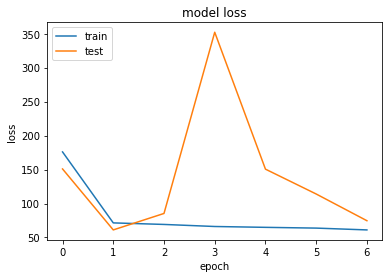

In [53]:
plot_loss_curves(history, output_path)

In [54]:
model = load_model(os.path.join(output_path, 'mlp_model_baseline.h5'))

In [62]:
predictions_train = model.predict(x_train_scaled).flatten()
evaluation(predictions_train, y_train, 'Train')

Train set:
MSE: 59.24740202282794
RMSE: 7.697233400568541
CMAPSS score: 7.493600192832575e+20
R2: 0.8359611350418542


In [55]:
predictions_test = model.predict(x_test_scaled).flatten()
evaluation(predictions_test, y_test)

Test set:
MSE: 47.65085246603329
RMSE: 6.902959688860517
CMAPSS score: 8.532521388510335e+18
R2: 0.8575293383323994


In [56]:
predictions_val = model.predict(x_val_scaled).flatten()
evaluation(predictions_val, y_val, 'Validation')

Validation set:
MSE: 61.1245858578581
RMSE: 7.818221399900242
CMAPSS score: 7404883423.049065
R2: 0.8317508134559316


In [27]:
x_train.describe()

,Wf,Nf,Nc,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,alt,TRA,T2
count,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06,4.495287e+06
mean,2.246982e+00,2.014315e+03,8.203450e+03,5.589538e+02,1.319009e+03,1.642581e+03,1.105524e+03,1.080502e+01,8.227008e+00,1.096956e+01,1.357597e+01,2.078485e+02,2.113974e+02,8.011887e+00,2.195349e+04,6.860208e+01,4.748620e+02
std,5.669091e-01,1.384093e+02,1.839979e+02,1.797591e+01,5.547321e+01,9.837773e+01,5.166616e+01,2.145808e+00,1.766716e+00,2.178485e+00,2.617782e+00,4.382677e+01,4.447162e+01,1.900070e+00,6.313032e+03,1.453999e+01,1.665756e+01
min,3.279842e-01,1.469742e+03,7.366108e+03,4.841972e+02,1.068823e+03,9.445005e+02,6.901948e+02,5.917596e+00,4.373175e+00,6.007711e+00,6.914424e+00,8.033988e+01,8.210175e+01,4.129309e+00,1.000100e+04,2.355452e+01,4.213779e+02
25%,1.864492e+00,1.959656e+03,8.105007e+03,5.466101e+02,1.288390e+03,1.593953e+03,1.072569e+03,8.976690e+00,6.672743e+00,9.113391e+00,1.145709e+01,1.773841e+02,1.804614e+02,6.371265e+00,1.651700e+04,5.941364e+01,4.605065e+02
50%,2.107214e+00,2.058522e+03,8.204305e+03,5.560642e+02,1.317866e+03,1.652645e+03,1.097053e+03,1.035381e+01,7.821310e+00,1.051148e+01,1.304733e+01,1.967872e+02,2.001841e+02,7.530022e+00,2.299900e+04,7.479439e+01,4.729416e+02
75%,2.558934e+00,2.111743e+03,8.316132e+03,5.710761e+02,1.352912e+03,1.700562e+03,1.137237e+03,1.248794e+01,9.670818e+00,1.267811e+01,1.543851e+01,2.338662e+02,2.378476e+02,9.497462e+00,2.799100e+04,7.962834e+01,4.892556e+02
max,4.539436e+00,2.263477e+03,8.745187e+03,6.167966e+02,1.487275e+03,1.912816e+03,1.276669e+03,1.691886e+01,1.226862e+01,1.717651e+01,2.198497e+01,3.724845e+02,3.781559e+02,1.321004e+01,3.503300e+04,8.745055e+01,5.108146e+02


In [28]:
x_val.describe()

,Wf,Nf,Nc,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,alt,TRA,T2
count,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000,768160.000000
mean,2.270443,2012.831376,8211.551444,559.670017,1321.243360,1642.971485,1107.960838,10.916905,8.320352,11.083152,13.701222,210.133980,213.736046,8.115639,21594.048002,68.227504,475.866390
std,0.563023,140.225364,184.318054,17.705095,55.580225,99.447636,51.398941,2.091749,1.724774,2.123603,2.553201,43.249960,43.877733,1.855681,6133.974885,14.599670,16.136875
min,0.670597,1486.269935,7366.466367,484.202497,1072.895343,1228.537245,884.040653,5.917624,4.373175,6.007740,6.914573,80.330756,82.093095,4.129153,10001.000000,24.609200,421.377893
25%,1.903019,1961.780536,8118.164924,547.650012,1292.238331,1596.036827,1075.764203,9.210827,6.871256,9.351093,11.715248,180.087763,183.215149,6.556973,16288.000000,59.677311,462.916438
50%,2.141862,2059.082747,8215.290024,557.539005,1321.138339,1654.725219,1100.371041,10.437394,7.897893,10.596339,13.137887,199.967092,203.388578,7.646297,22349.000000,74.354942,473.438795
75%,2.561952,2110.680316,8322.841360,571.306659,1354.594284,1699.374315,1138.016505,12.595039,9.787072,12.786842,15.529839,235.389358,239.447049,9.570440,26995.000000,79.628342,490.182431
max,4.305223,2222.218747,8678.287213,610.637816,1468.537464,1898.923768,1284.410062,16.374098,12.216071,16.623450,21.114727,354.267472,359.529337,12.993743,35033.000000,87.626328,510.292714


In [29]:
x_test.describe()

,Wf,Nf,Nc,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,alt,TRA,T2
count,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06,1.253743e+06
mean,2.403201e+00,1.999809e+03,8.230953e+03,5.649183e+02,1.327844e+03,1.648611e+03,1.118895e+03,1.174699e+01,9.020636e+00,1.192588e+01,1.467278e+01,2.223658e+02,2.262123e+02,8.851139e+00,1.910834e+04,6.555718e+01,4.822338e+02
std,6.037376e-01,1.468721e+02,1.931254e+02,1.812375e+01,5.811396e+01,1.041488e+02,5.303728e+01,2.176814e+00,1.787953e+00,2.209963e+00,2.666418e+00,4.596197e+01,4.661605e+01,1.937761e+00,6.175012e+03,1.507279e+01,1.618800e+01
min,3.416258e-01,1.471017e+03,7.396578e+03,5.045053e+02,1.070961e+03,9.540545e+02,6.976268e+02,7.152428e+00,5.507010e+00,7.261349e+00,8.598599e+00,8.225872e+01,8.577351e+01,4.949927e+00,1.000100e+04,2.355452e+01,4.416871e+02
25%,1.972566e+00,1.918627e+03,8.125872e+03,5.518893e+02,1.295088e+03,1.596720e+03,1.083440e+03,9.977838e+00,7.567901e+00,1.012979e+01,1.255894e+01,1.878106e+02,1.911433e+02,7.234730e+00,1.313600e+04,5.484336e+01,4.696360e+02
50%,2.278735e+00,2.033749e+03,8.234230e+03,5.626667e+02,1.327539e+03,1.657730e+03,1.112218e+03,1.150901e+01,8.810251e+00,1.168427e+01,1.432719e+01,2.122920e+02,2.159778e+02,8.589801e+00,1.941300e+04,6.996044e+01,4.817885e+02
75%,2.780043e+00,2.115296e+03,8.356755e+03,5.775744e+02,1.365424e+03,1.714233e+03,1.154108e+03,1.354695e+01,1.067996e+01,1.375325e+01,1.672680e+01,2.532535e+02,2.575437e+02,1.062363e+01,2.399400e+04,7.892522e+01,4.967878e+02
max,4.164751e+00,2.207594e+03,8.668865e+03,6.115321e+02,1.463065e+03,1.880632e+03,1.269264e+03,1.667285e+01,1.229306e+01,1.692675e+01,2.142393e+01,3.522265e+02,3.578323e+02,1.289760e+01,3.102800e+04,8.648376e+01,5.111071e+02
